In [1]:
import numpy as np
import c2qa
import c2qa.util
from qiskit import ClassicalRegister
from qutip import *
from qiskit import QuantumCircuit, QuantumRegister
from qiskit_aer import Aer
from qiskit import transpile
import numpy as np
from scipy.optimize import minimize
from numpy import pi, sqrt
import math
import random
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import simps


In [2]:
cutoff = 10  # same as cutoff_dim in SF
qmr = c2qa.QumodeRegister(1, num_qubits_per_qumode=int(np.ceil(np.log2(cutoff))))
cr = ClassicalRegister(1)
circuit = c2qa.CVCircuit(qmr, cr)

# Initialize to Fock state |2>
circuit.cv_initialize(2, qmr[0])

# Simulate
state, _, _ = c2qa.util.simulate(circuit)

# Compute Wigner
w = c2qa.wigner.wigner(state, axes_max=4, axes_min=-4, axes_steps=80)

In [3]:
from scipy.stats.contingency import margins

x_dist, y_dist = margins(w.T)  # x-axis: position, y-axis: momentum


In [4]:
xaxis = np.linspace(-4, 4, 80)
x_dist *= (8 / 80)  # Normalize over range


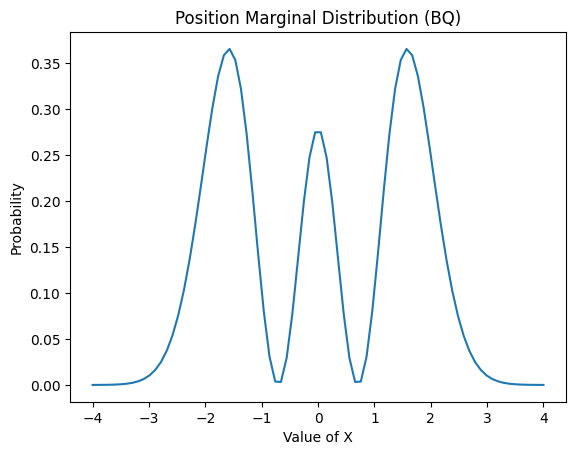

In [5]:
import matplotlib.pyplot as plt

plt.plot(xaxis, x_dist)
plt.xlabel("Value of X")
plt.ylabel("Probability")
plt.title("Position Marginal Distribution (BQ)")
plt.show()

In [6]:
hbar = 0.5

parabolic_min = 0.83  # Equivalent to parabolic_min


In [7]:
def function_optimize(x, parabolic_min):
    return (x - parabolic_min)**2


In [8]:
def cost_ham(qc, mode, p):
    momentum_shift = parabolic_min * 2 * hbar * p
    # Use the circuit's displacement gate method (assuming it's implemented)
    # qc.cv_d(alpha=momentum_shift, qumode=[mode])
    qc.cv_d(alpha=momentum_shift, qumode=mode)
    # Pgate placeholder
    # print("Pgate not implemented")
    # return qc

## 🧮 Implementing Custom Hamiltonians in Bosonic Quantum Circuits

### Method 1: Direct Hamiltonian Exponentiation
Construct the unitary directly from the Hamiltonian:
``U = exp(-i γ p²)``

- ✅ High theoretical precision  
- ✅ Useful for ideal simulations  
- ❌ Often not supported natively in hardware or libraries  
- ❌ Hard to implement without low-level backend access  

---

### Method 2: Gate-Based Approximation (Decomposition)
Approximate the effect of the Hamiltonian using supported bosonic gates:

- **Squeezing**: `cv_sq`  
- **Rotation**: `cv_r`  
- **Displacement**: `cv_d`

Example:
``exp(-i γ p²) ≈ R(π/2) · exp(-i γ x²) · R(-π/2)``

- ✅ Hardware-compatible and simulation-friendly  
- ✅ Expressed using standard gate sets  
- ❌ Approximate — quality depends on circuit depth and truncation  

---

### ✅ Chosen Approach: Gate-Based Approximation

To ensure compatibility with the C2QA (bosonic-qiskit) stack and practical simulation/testing,  
we proceed with **approximating target unitaries using available gates** rather than constructing custom unitaries from scratch.

This allows us to simulate realistic circuits while remaining aligned with the supported gate set.


In [9]:
def mixer_ham(circuit: QuantumCircuit, q: list, p: float):
    """
    Approximated kinetic mixer unitary for QAOA using supported C2QA gates.

    Args:
        circuit (QuantumCircuit): Qiskit circuit object to which gates are added.
        q (list): list of qubits representing the bosonic mode.
        p (float): parameter controlling the evolution strength.
        hbar (float): effective hbar (default = 1.0).
    """
    gamma = -hbar * p

    # Rotate to x-basis
    circuit.cv_r(-np.pi / 2, q)

    # Apply squeezed gate as a crude approximation of exp(-i gamma x^2)
    # Note: This is only an approximation. A better approximation would involve layered gates or a custom gate.
    # circuit.cv_sq(gamma, 0, q)
    circuit.cv_sq(gamma, q)

    # Rotate back to p-basis
    circuit.cv_r(np.pi / 2, q)

In [10]:
#Defines the circuit depth, cutoff dimension, and the squeezing parameter

circuit_depth = 3
squeezing = -0.5
cutoff = 5

In [11]:
def run_circuit(param):
    # Use global variables defined elsewhere
    num_qubits_per_qumode = int(np.ceil(np.log2(cutoff)))
    qmr = c2qa.QumodeRegister(1, num_qubits_per_qumode=num_qubits_per_qumode)
    cr = ClassicalRegister(num_qubits_per_qumode, "c0")
    circuit = c2qa.CVCircuit(qmr, cr)

    circuit.cv_sq(squeezing, [qmr[0]])

    param1 = [param[0]] * circuit_depth
    param2 = [param[0]] * circuit_depth

    for i in range(circuit_depth):
        cost_ham(circuit, qmr, param1[i])
        mixer_ham(circuit, qmr, param2[i])

    backend = Aer.get_backend("aer_simulator_statevector") #AerSimulator(method='statevector')
    circuit.save_statevector()

    compiled_circuit = transpile(circuit, backend)
    result = backend.run(compiled_circuit).result()
    statevector = result.get_statevector()

    # x_vals = [i/10 for i in range(-30, 30)]
    # y_vals = x_vals

    # # wigner = c2qa.util.wigner(statevector, x_vals, y_vals)
    # wigner = get_wigner(statevector, cutoff, x_vals, y_vals)

    # Set axes limits and steps (tune these)
    ax_max = 3
    ax_min = -3
    steps = 50

    # Compute Wigner function using c2qa
    wigner = c2qa.wigner.wigner(statevector, axes_max=ax_max, axes_min=ax_min, axes_steps=steps)


    return wigner


In [12]:
def old_circuit(param):
    # qmr = c2qa.QumodeRegister(1) #, cutoff_dim=cutoff)
    num_qubits_per_qumode = int(np.ceil(np.log2(cutoff)))
    qmr = c2qa.QumodeRegister(1, num_qubits_per_qumode=int(np.ceil(np.log2(cutoff))))
    # cr = ClassicalRegister(1)
    cr = ClassicalRegister(num_qubits_per_qumode, "c0")     # match the same width
    circuit = c2qa.CVCircuit(qmr, cr)

    param1 = [param[0] for _ in range(circuit_depth)]
    param2 = [param[0] for _ in range(circuit_depth)]

    # circuit.cv_sq(squeezing, 0, qmr[0])
    circuit.cv_sq(squeezing, [qmr[0]])

    for i in range(circuit_depth):
        cost_ham(circuit, qmr, param1[i])
        mixer_ham(circuit, qmr, param2[i])

    # circuit.measure_quadrature(qmr[0], "x", cr[0])
    # circuit.measure_x(qmr[0], cr[0])
    circuit.measure_x(qmr[0], cr)
    

    # backend = c2qa.StatevectorSimulator()
    # job = backend.run(circuit)
    # result = job.result()


    from qiskit_aer import Aer
    from qiskit import transpile

    backend = Aer.get_backend("aer_simulator_statevector")
    # Transpile and run
    circuit.save_statevector()
    compiled_circuit = transpile(circuit, backend)
    # result = backend.run(compiled_circuit).result()
    result = backend.run(compiled_circuit, memory=True).result()
    # print('masTestResultOldCircuit',result.results[0].data)
    statevector = result.get_statevector()
    samples = result.get_memory(circuit)

    return int(samples[0])

In [13]:
#Defines the number of iterations that the circuit is sampled

shots = 15

In [14]:
#Defines the objective function that is minimized

def objective(param):

    costly = 0

    for i in range(0, shots):

        av = old_circuit(param)
        result1 = av
        calculation = function_optimize(result1, parabolic_min)
        costly = costly + calculation

    costly = costly/shots


    print("Paramter: "+str(param))
    print("Value of Cost Function: "+str(costly))

    return costly

In [15]:
#Defines the optimizer that minimizes the objective function

out = minimize(objective, x0=[random.randint(-150,150)/100], method="Nelder-Mead", options={'maxiter':20})
print(out)

#Creates the graphical visualization

# final = run_circuit(out['x'])

# x = [i/10 for i in range(-30, 30)]
# y = []


# for i in range(0, len(x)):
#     res = simps([final[k][i] for k in range(0, len(x))], x)
#     y.append(res)

# plt.plot(x, y)
# plt.plot([parabolic_min, parabolic_min, parabolic_min, parabolic_min, parabolic_min], [0, 0.25*max(y), 0.5*max(y), 0.75*max(y), max(y)])

# plt.show()

c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.65]
Value of Cost Function: 5859.352900000002


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.6825]
Value of Cost Function: 5076.815566666668


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.715]
Value of Cost Function: 4015.534233333334


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.7475]
Value of Cost Function: 1334.1289000000004


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.8125]
Value of Cost Function: 1985.4142333333336


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.78]
Value of Cost Function: 3456.570233333334


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.715]
Value of Cost Function: 4132.2649


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.78]
Value of Cost Function: 2123.0182333333337


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.76375]
Value of Cost Function: 1985.3702333333338


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.73125]
Value of Cost Function: 3953.006233333334


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.755625]
Value of Cost Function: 1974.2502333333337


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.739375]
Value of Cost Function: 3428.570233333334


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.7515625]
Value of Cost Function: 2000.8289000000007


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.7515625]
Value of Cost Function: 1347.7835666666667


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.7434375]
Value of Cost Function: 2018.6662333333331


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.74953125]
Value of Cost Function: 689.5169000000001


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.7515625]
Value of Cost Function: 3621.162233333334


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.74851563]
Value of Cost Function: 2118.747566666667


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.74851563]
Value of Cost Function: 1994.3449000000005


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.75054688]
Value of Cost Function: 3755.6969


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.74902344]
Value of Cost Function: 3939.7609000000007


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.74902344]
Value of Cost Function: 2405.5529


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.75003906]
Value of Cost Function: 2127.810233333334


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.74978516]
Value of Cost Function: 1469.5435666666672


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.74927734]
Value of Cost Function: 2634.1209000000003


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.7496582]
Value of Cost Function: 1317.3169


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.7494043]
Value of Cost Function: 2782.0329000000006


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.74959473]
Value of Cost Function: 1967.3569


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.74959473]
Value of Cost Function: 1341.6822333333332


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.74946777]
Value of Cost Function: 686.5795666666667


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.7494043]
Value of Cost Function: 806.1702333333328


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.7494043]
Value of Cost Function: 1972.9169000000002


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.74949951]
Value of Cost Function: 2123.0182333333337


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.74949951]
Value of Cost Function: 3958.610233333334


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.74943604]
Value of Cost Function: 2641.8502333333336


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.7494519]
Value of Cost Function: 2006.4329


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.74948364]
Value of Cost Function: 3964.1702333333337


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.74945984]
Value of Cost Function: 1986.2502333333334


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.74947571]
Value of Cost Function: 3571.0982333333345


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.74946381]
Value of Cost Function: 17.324900000000003


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.74945984]
Value of Cost Function: 680.6982333333333


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.74946182]
Value of Cost Function: 2900.6555666666673


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.74946579]
Value of Cost Function: 2659.8635666666673


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.74946182]
Value of Cost Function: 1979.8102333333336


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.74946281]
Value of Cost Function: 3303.010233333334


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.7494648]
Value of Cost Function: 4103.019566666667


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.74946281]
Value of Cost Function: 1978.4769000000001


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.74946331]
Value of Cost Function: 3608.6649


c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(
c:\Users\mhakimi\Documents\bosonicqiskit\BosonicQiskitVenv\lib\site-packages\c2qa\circuit.py:969: UserWarning: Probe qubits not in use, set probe_measure to True for measure support.
  warnings.warn(


Paramter: [-0.7494643]
Value of Cost Function: 3284.204900000001
       message: Maximum number of iterations has been exceeded.
       success: False
        status: 2
           fun: 17.324900000000003
             x: [-7.495e-01]
           nit: 20
          nfev: 49
 final_simplex: (array([[-7.495e-01],
                       [-7.495e-01]]), array([ 1.732e+01,  3.284e+03]))


In [16]:
print(out['x'])

[-0.74946381]


In [17]:
final = run_circuit(out['x'])


C:\Users\mhakimi\AppData\Local\Temp\ipykernel_38180\1603119491.py:13: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  res = simps([final[k][i] for k in range(0, len(x))], x)


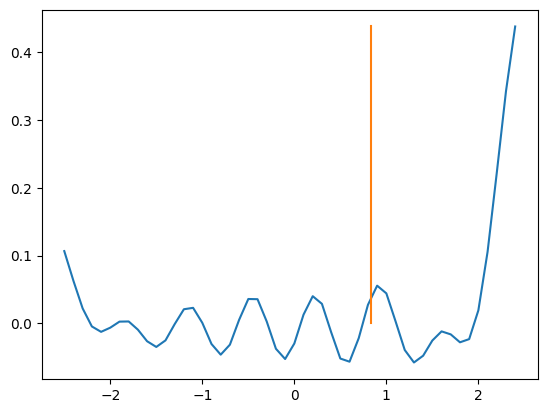

In [18]:
# final = run_circuit(out['x'])

# x = [i/10 for i in range(-30, 30)]
size = len(final)  # number of points on each axis
half_range = size // 2

# Create x grid matching the Wigner matrix size, centered at zero, with step 0.1 (adjust if needed)
x = [i/10 for i in range(-half_range, half_range)]
y = []

# from scipy.integrate import simps
for i in range(0, len(x)):
    res = simps([final[k][i] for k in range(0, len(x))], x)
    y.append(res)

plt.plot(x, y)
plt.plot([parabolic_min, parabolic_min, parabolic_min, parabolic_min, parabolic_min], [0, 0.25*max(y), 0.5*max(y), 0.75*max(y), max(y)])

plt.show()